In [1]:
import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

LABELS = ['pocket','swing','texting','whatever'] 

### read raw data files and add label colomn by parsing the file name 

In [2]:
def loadFile(root,file):
    print 'loading : ' , file 
    data=pd.read_csv(os.path.join(root,file))
    data['source']=file  
    for label in LABELS:
        if file.lower().startswith(label.lower()):
            # print 'add label : ', label
            data['label']=label
            return data
    data['label']=LABELS[-1]
    return data

In [3]:
def loadFiles(inputDir):
    print 'loading files from : ' , inputDir 
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [4]:
rdf = loadFiles(r'../raw-data/utf8')

loading files from :  ../raw-data/utf8
loading :  Texting2.csv
loading :  SwingRightPhoneDownScBody.csv
loading :  SwingRight2.csv
loading :  swing3.csv
loading :  swing2.csv
loading :  swing4.csv
loading :  Pocket2.csv
loading :  swingLeftHandPhoneDownScBody.csv
loading :  TextingPointingDorwatd.csv
loading :  PocketLeftAidePhoneDownScBodyLoose.csv


In [5]:
rdf.head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,Unnamed: 11,source,label
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1848,-38.2660,-21.8094,NaN,Texting2.csv,texting
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,NaN,Texting2.csv,texting
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,NaN,Texting2.csv,texting
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.8348,-37.9395,-21.8979,NaN,Texting2.csv,texting
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4193,-8.8348,-37.9395,-21.8979,NaN,Texting2.csv,texting


In [6]:
rdf.dropna(axis=1,inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78392 entries, 0 to 8755
Data columns (total 13 columns):
time      78392 non-null float64
gfx       78392 non-null float64
gFy       78392 non-null float64
gFz       78392 non-null float64
wx        78392 non-null float64
wy        78392 non-null float64
wz        78392 non-null float64
p         78392 non-null float64
Bx        78392 non-null float64
By        78392 non-null float64
Bz        78392 non-null float64
source    78392 non-null object
label     78392 non-null object
dtypes: float64(11), object(2)
memory usage: 8.4+ MB


In [7]:
rdf.head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,source,label
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1848,-38.2660,-21.8094,Texting2.csv,texting
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.8348,-37.9395,-21.8979,Texting2.csv,texting
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4193,-8.8348,-37.9395,-21.8979,Texting2.csv,texting


## preprocessing 
#### todos :lowpass filter , remove dc & normlaize 


## generate features 
#### todos : calculate norm feature for g-force , gyro 
####  avarage norm on sliding window 

In [8]:
rdf['gforce'] = np.sqrt(rdf['gfx']**2 + rdf['gFy']**2 + rdf['gFz']**2) 
rdf['gyro'] = np.sqrt(rdf['wx']**2 + rdf['wy']**2 + rdf['wz']**2) 

In [9]:
rdf.head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,source,label,gforce,gyro
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1848,-38.2660,-21.8094,Texting2.csv,texting,0.970810,0.18897
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting,0.970810,0.18897
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.1085,-37.5809,-22.7829,Texting2.csv,texting,1.065977,0.18897
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4330,-8.8348,-37.9395,-21.8979,Texting2.csv,texting,1.065977,0.18897
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.109,978.4193,-8.8348,-37.9395,-21.8979,Texting2.csv,texting,1.065977,0.18897


In [10]:
rdf['mgforce'] = rdf['gforce'].rolling(window=128,center=False).mean()
rdf['mgforce'].fillna(value=rdf['mgforce'].mean(),inplace=True)

rdf['mgyro'] = rdf['gyro'].rolling(window=128,center=False).mean()
rdf['mgyro'].fillna(value=rdf['mgyro'].mean(),inplace=True)


In [11]:
rdf['vgforce'] = rdf['gforce'].rolling(window=128,center=False).var()
rdf['vgforce'].fillna(value=rdf['vgforce'].mean(),inplace=True)
rdf['vgyro'] = rdf['gyro'].rolling(window=128,center=False).mean()
rdf['vgyro'].fillna(value=rdf['vgyro'].mean(),inplace=True)

In [12]:
#rdf.dropna(inplace=True)
rdf.drop('source',axis=1).head(10)

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,Bz,label,gforce,gyro,mgforce,mgyro,vgforce,vgyro
0,0.020,-0.0148,0.3461,0.9069,0.1421,0.0603,0.1090,978.4330,-8.1848,-38.2660,-21.8094,texting,0.970810,0.188970,1.159161,1.833778,0.169561,1.833778
1,0.025,-0.0148,0.3461,0.9069,0.1421,0.0603,0.1090,978.4330,-8.1085,-37.5809,-22.7829,texting,0.970810,0.188970,1.159161,1.833778,0.169561,1.833778
2,0.032,-0.0383,0.3321,1.0122,0.1421,0.0603,0.1090,978.4330,-8.1085,-37.5809,-22.7829,texting,1.065977,0.188970,1.159161,1.833778,0.169561,1.833778
3,0.067,-0.0383,0.3321,1.0122,0.1421,0.0603,0.1090,978.4330,-8.8348,-37.9395,-21.8979,texting,1.065977,0.188970,1.159161,1.833778,0.169561,1.833778
4,0.076,-0.0383,0.3321,1.0122,0.1421,0.0603,0.1090,978.4193,-8.8348,-37.9395,-21.8979,texting,1.065977,0.188970,1.159161,1.833778,0.169561,1.833778
5,0.110,-0.0074,0.3477,0.8704,0.1421,0.0603,0.1090,978.4193,-8.8348,-37.9395,-21.8979,texting,0.937308,0.188970,1.159161,1.833778,0.169561,1.833778
6,0.115,-0.0074,0.3477,0.8704,0.0855,-0.0155,0.0556,978.4193,-8.8348,-37.9395,-21.8979,texting,0.937308,0.103159,1.159161,1.833778,0.169561,1.833778
7,0.116,-0.0074,0.3477,0.8704,0.0855,-0.0155,0.0556,978.4193,-8.8348,-37.9395,-21.8979,texting,0.937308,0.103159,1.159161,1.833778,0.169561,1.833778
8,0.147,-0.0074,0.3477,0.8704,0.0855,-0.0155,0.0556,978.4193,-9.1873,-37.8632,-21.3715,texting,0.937308,0.103159,1.159161,1.833778,0.169561,1.833778
9,0.169,-0.0013,0.3385,0.9399,0.0855,-0.0155,0.0556,978.4193,-9.1873,-37.8632,-21.3715,texting,0.998997,0.103159,1.159161,1.833778,0.169561,1.833778


### visualize

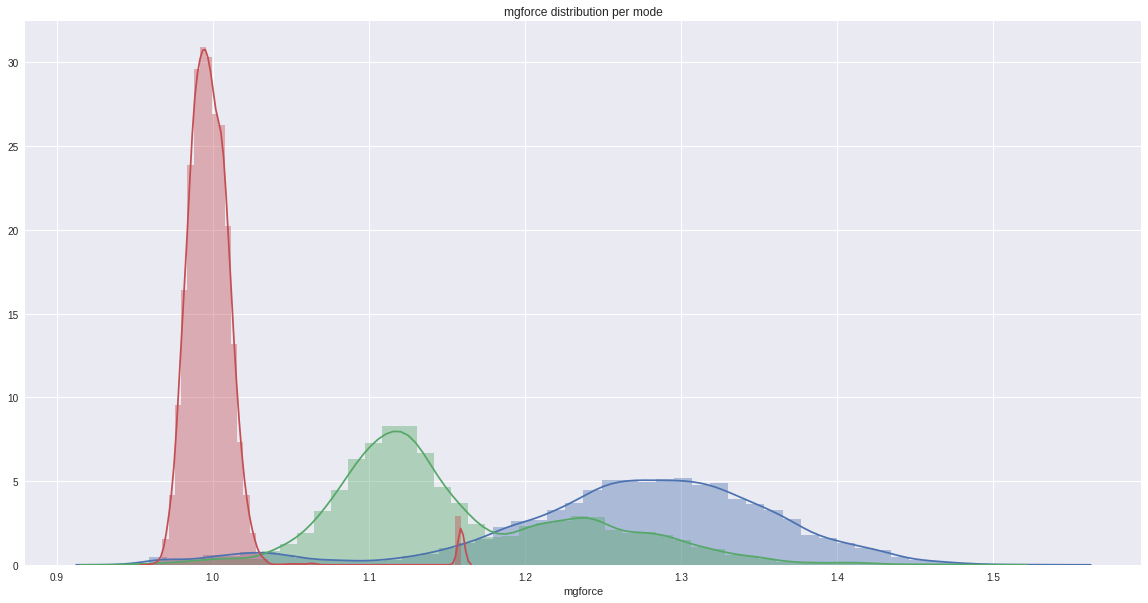

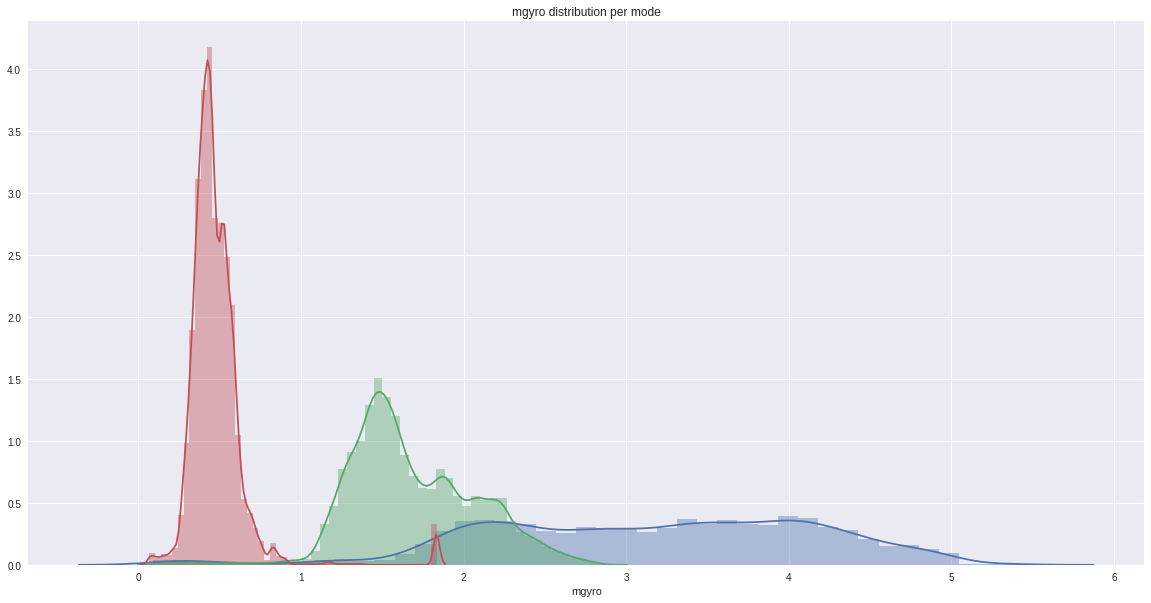

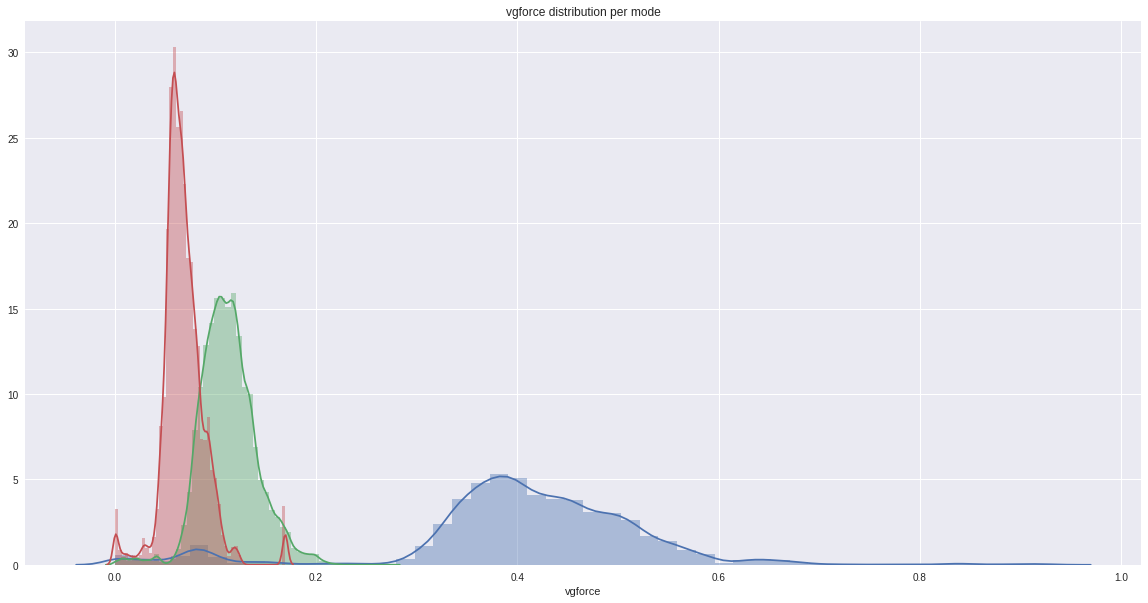

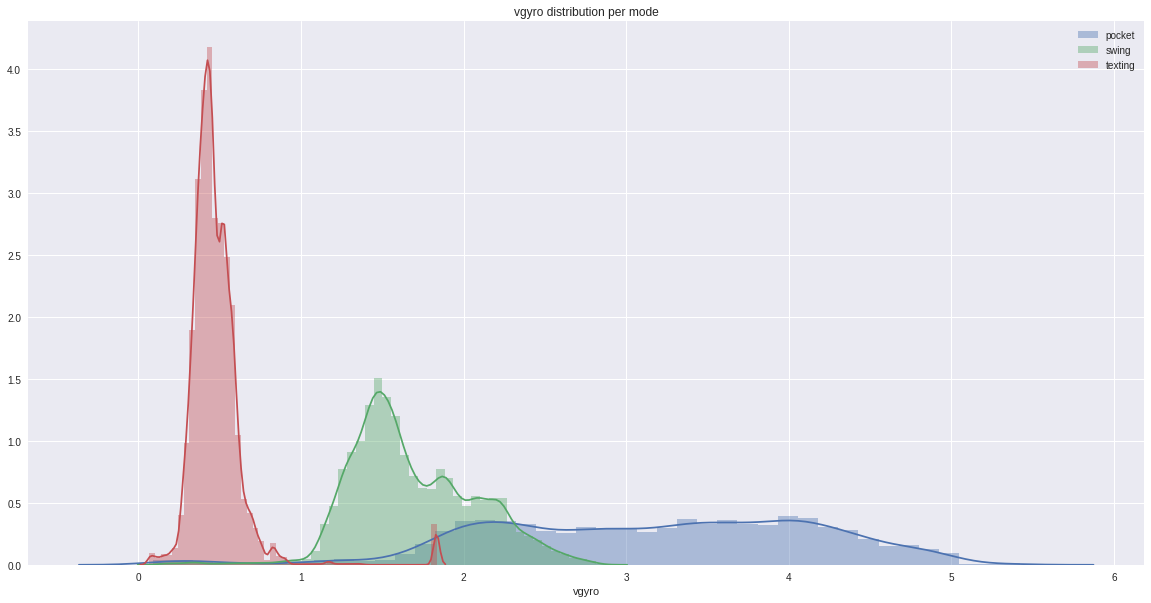

In [13]:
features = ['mgforce','mgyro','vgforce','vgyro']
for f in features:
    plt.figure(figsize=(20,10))
    plt.title(f + " distribution per mode")
    for l in LABELS:    
        if l != 'whatever':
            sns.distplot(rdf[rdf.label == l][f], label=l)
plt.legend()
plt.show()

## split train & test data

In [ ]:
from sklearn.model_selection import train_test_split
